# EGFR Signal Transduction Specific Visualization

In [1]:
import os
os.chdir("../")

In [2]:
import glob
import gzip
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from modelproblem import ModelProblem
from petab.visualize import plot_problem
from weighted_quantile import weighted_quantile
from result_classes import Result,MethodResults

In [3]:
prob_name = "EGFR"
methods = ["smc", "pmc"]#, "ptmcmc"]
colors = sns.color_palette("tab10", n_colors=len(methods))

mod_prob = ModelProblem(prob_name)
mod_prob.initialize()

grouped_results = [MethodResults(x) for x in methods]

for method, group_obj in zip(methods, grouped_results):
	result_dir = f"results/{prob_name}/{method}/"
	fnames = glob.glob(result_dir + "*.pkl")
	for fname in fnames:
		with gzip.open(fname, "rb") as f:
			results = pickle.load(f)
		result_obj = Result(results)
		group_obj.add_result(result_obj)	

Text(0, 0.5, '% of Parameter Space Covered\nfor Parameter Ea_RPL ')

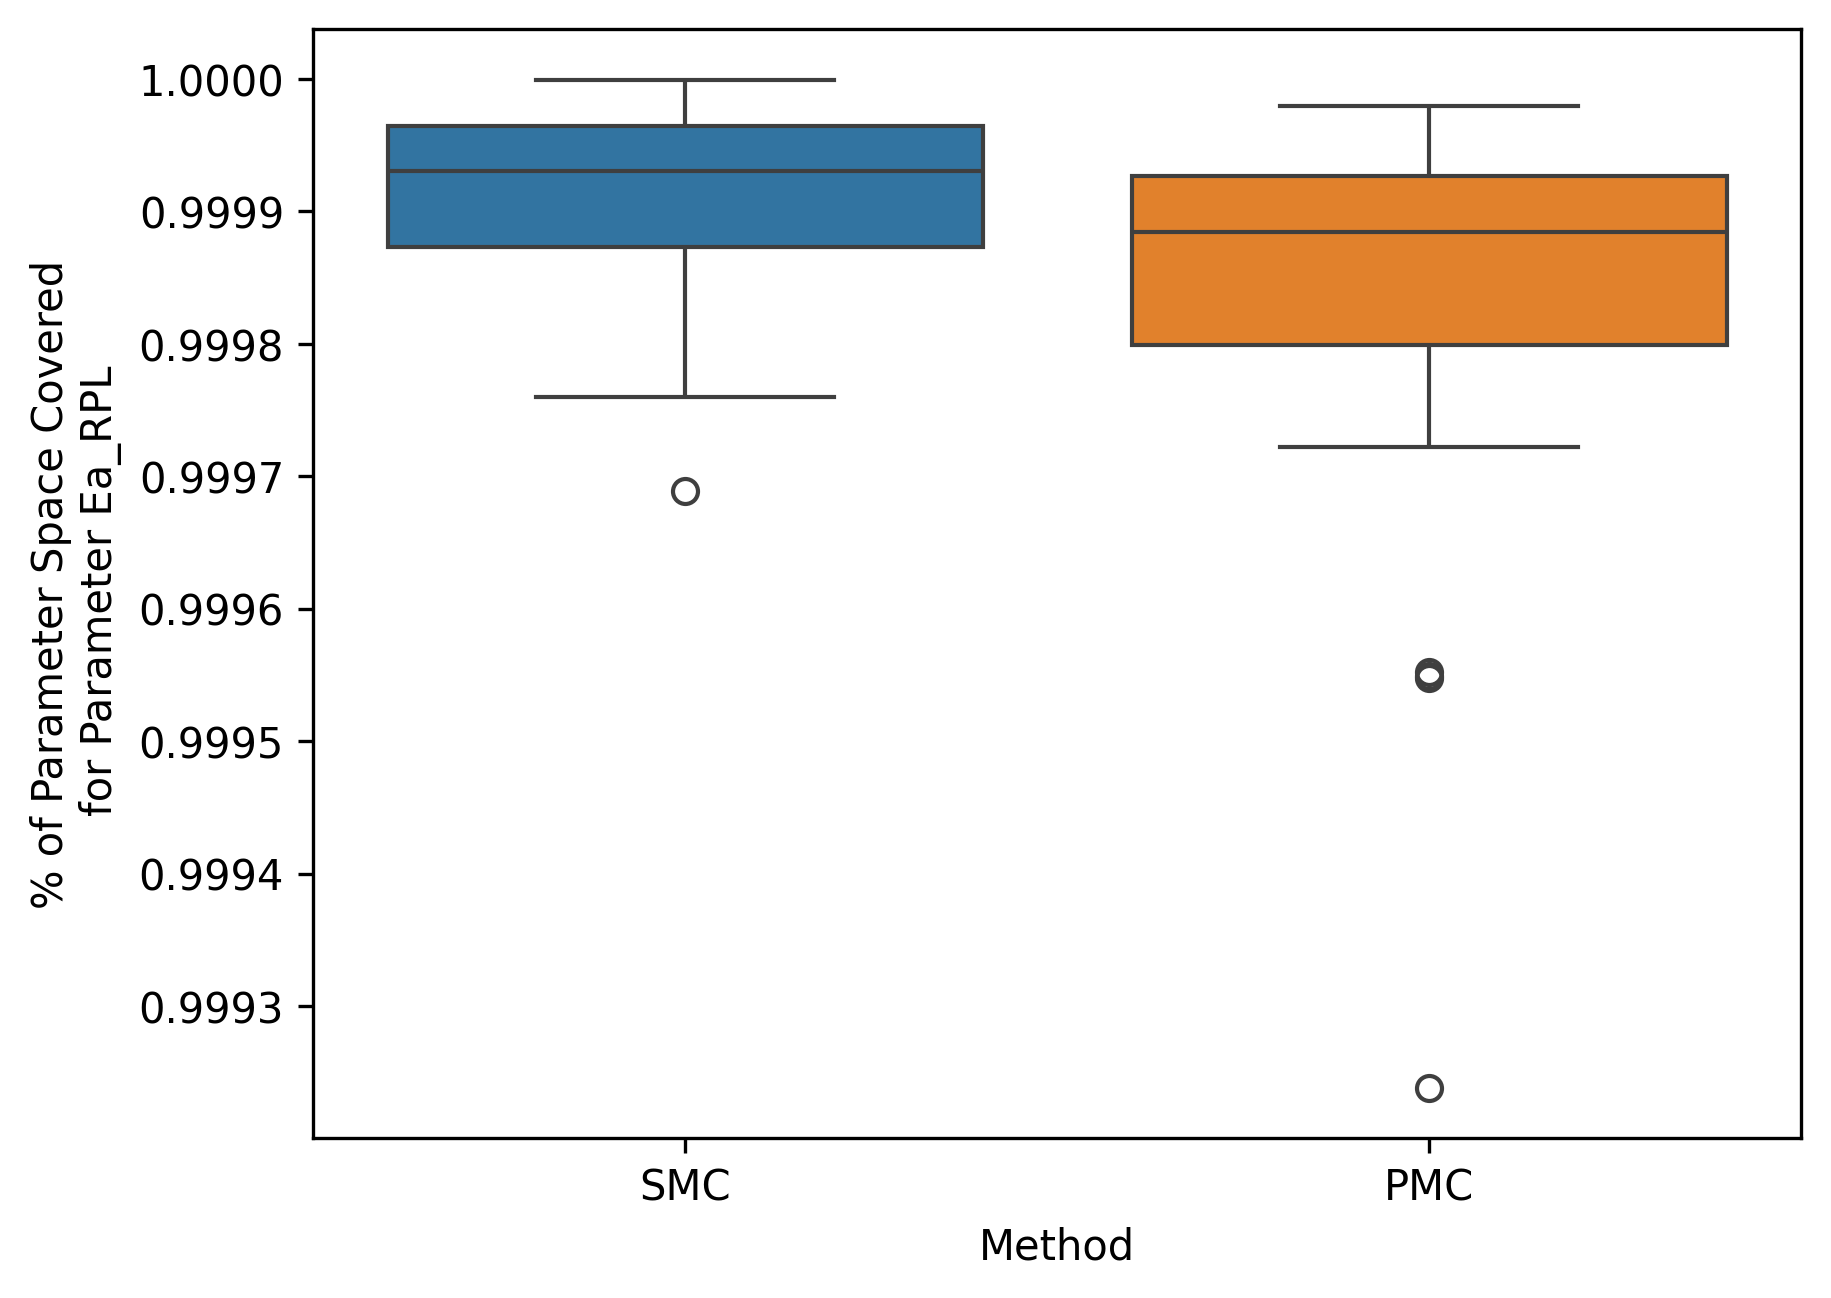

In [4]:
fixed_idxs = mod_prob.problem.x_fixed_indices
par_names = mod_prob.problem.x_names
x=np.array(par_names)
mask=np.full(len(par_names),True,dtype=bool)
mask[fixed_idxs]=False
fit_par_names=x[mask]

dummy_idx = -1

par_bounds = mod_prob.bounds
plt.figure(dpi=300)
ratios = np.array([x.get_sampling_efficiency(par_bounds, dummy_idx) for x in grouped_results], dtype=object)
ratio_df = pd.DataFrame()
for ratio_arr, method in zip(ratios, methods):
	temp_df = pd.DataFrame()
	temp_df[method] = ratio_arr
	ratio_df = pd.concat([ratio_df, temp_df])

sns.boxplot(ratio_df, showfliers=True)
plt.xticks(range(len(methods)), [x.abbr for x in grouped_results])
plt.xlabel("Method"); plt.ylabel(f"% of Parameter Space Covered\nfor Parameter {fit_par_names[-1]} ")

## Select best result for each method

In [6]:
llhs = np.array([x.get_avg_llhs() for x in grouped_results], dtype=object)
best_runs = [np.argmax(x) for x in llhs]
best_results = [res.all_runs[best_idx] for best_idx, res in zip(best_runs, grouped_results)]

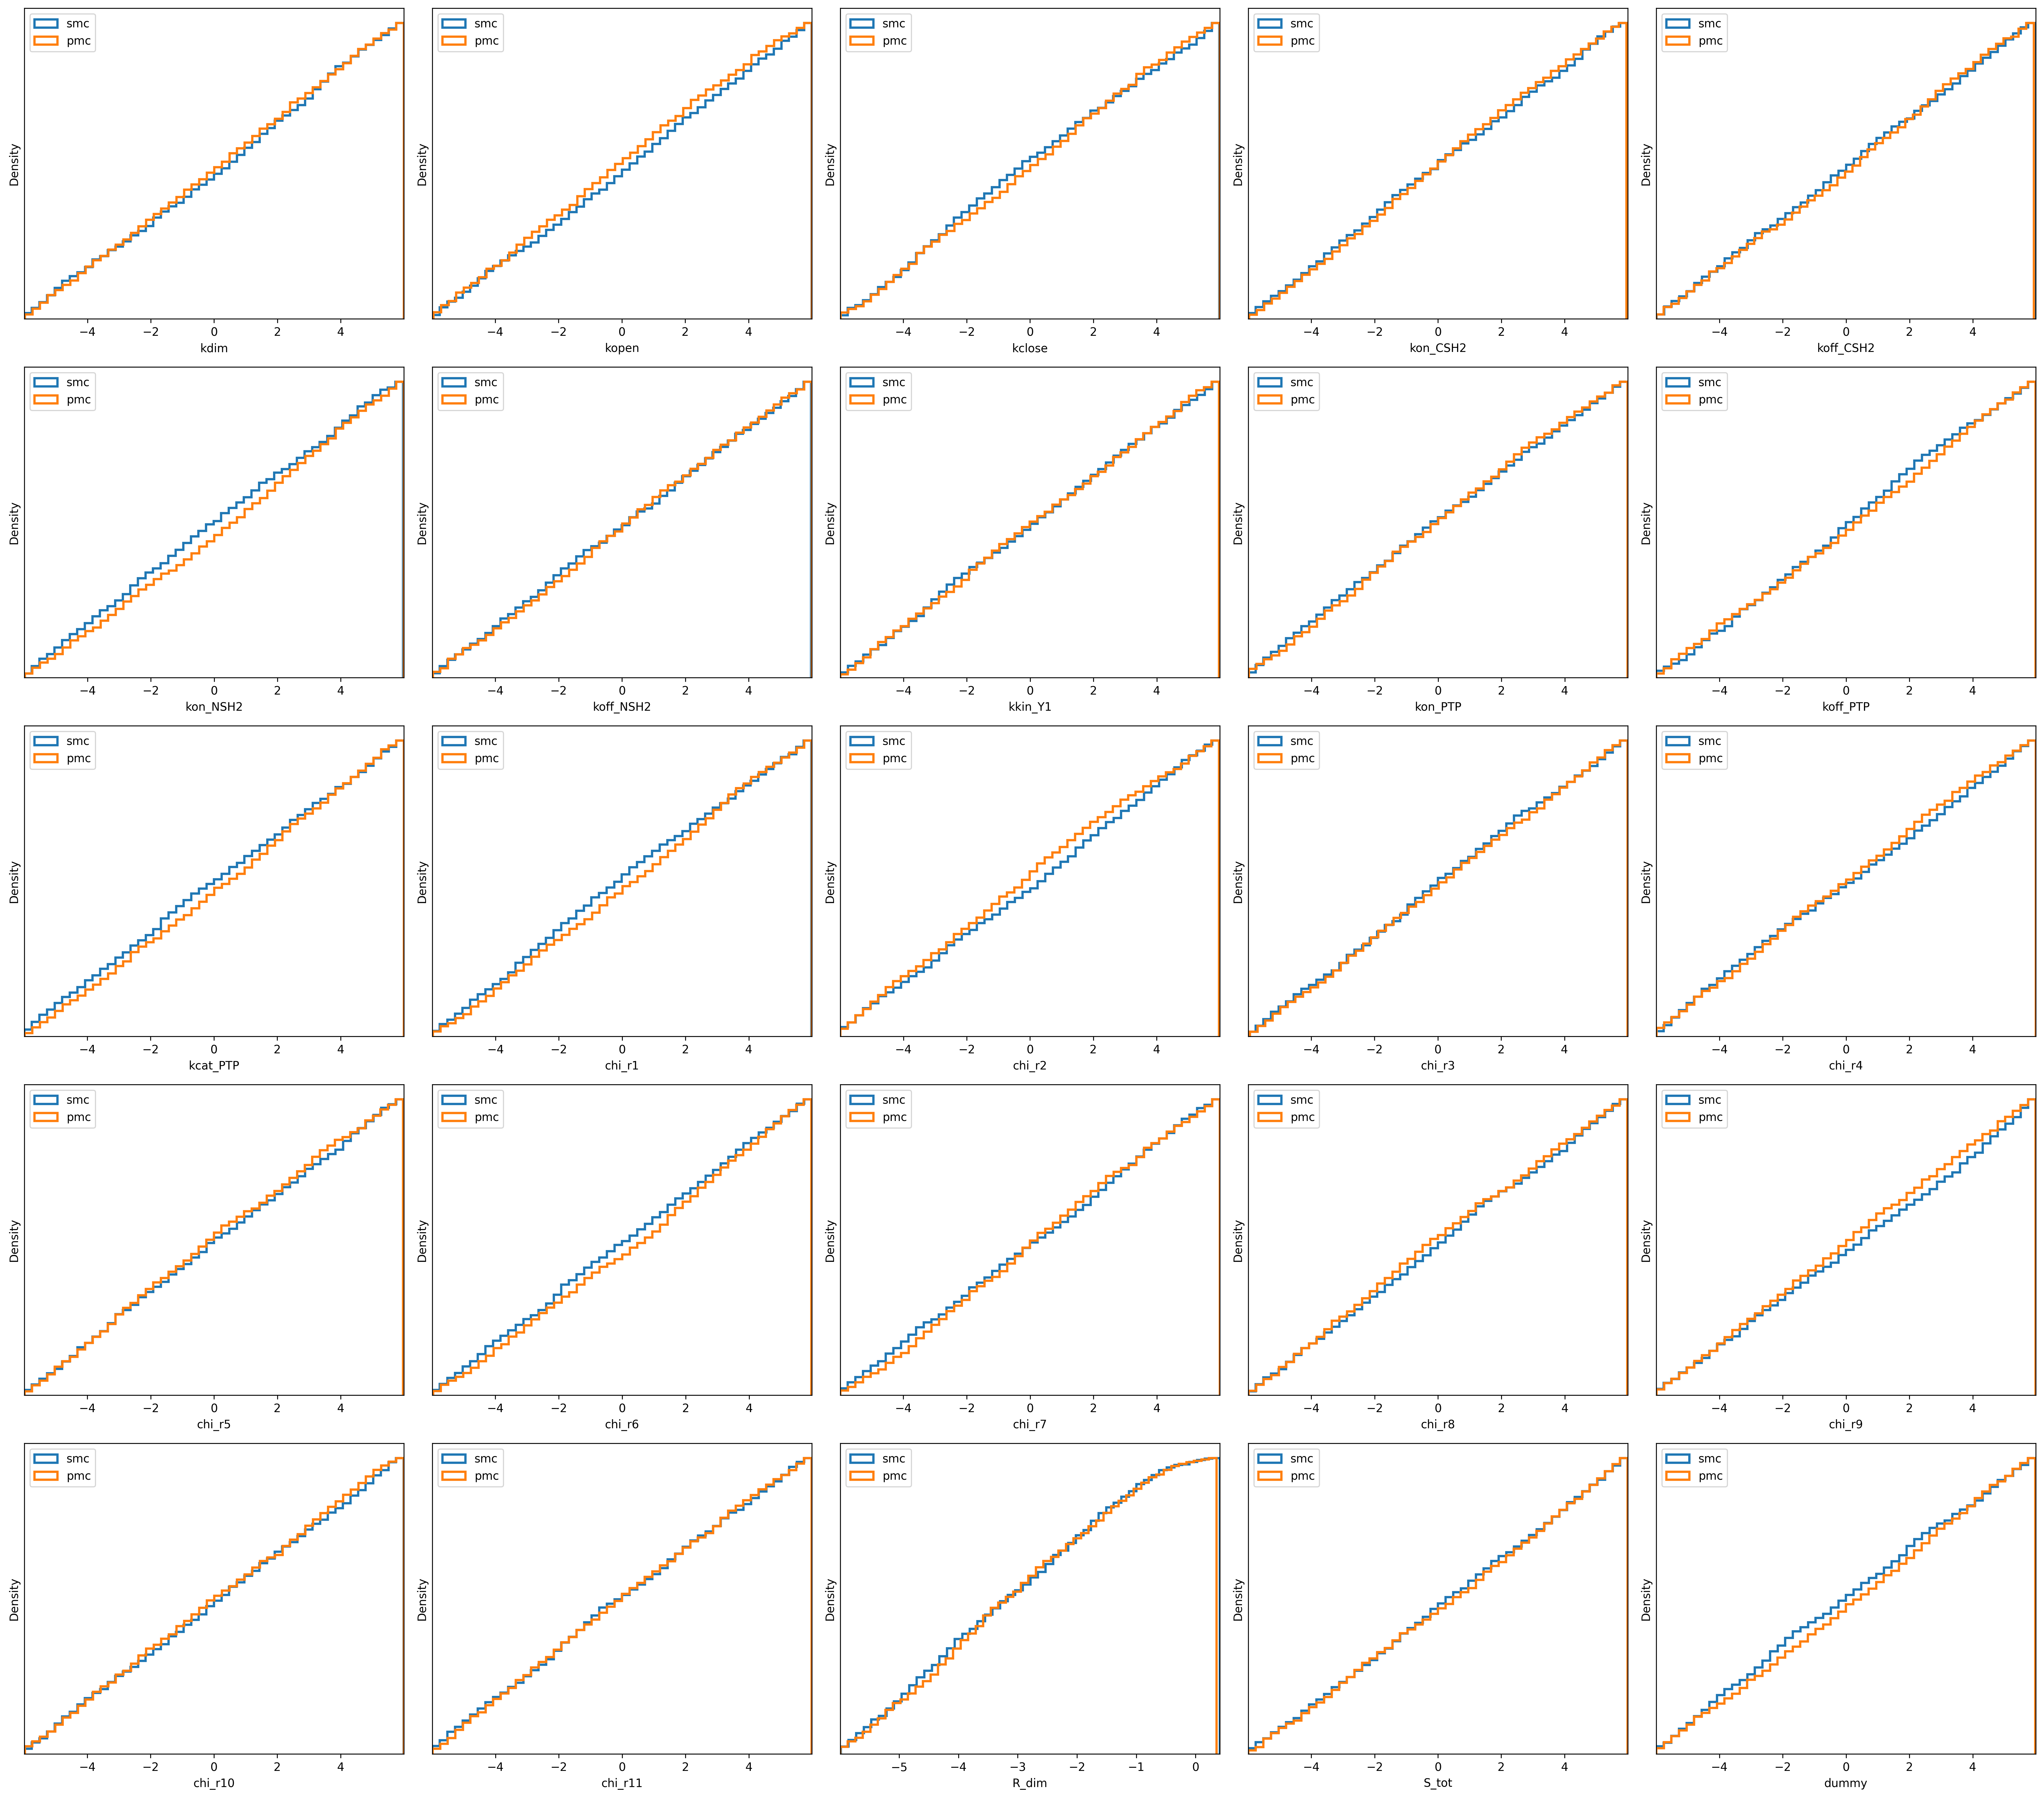

In [ ]:
fixed_idxs = mod_prob.problem.x_fixed_indices
par_names = mod_prob.problem.x_names
x=np.array(par_names)
mask=np.full(len(par_names),True,dtype=bool)
mask[fixed_idxs]=False
fit_par_names=x[mask]

par_bounds = mod_prob.bounds
histtype = "step"
alpha=1

plt.figure(figsize=(25,22), dpi=300)
for i, par_name in enumerate(fit_par_names): 
	plt.subplot(5,5,i+1)
	for j in range(len(best_results)):      
		cur_result = best_results[j]
		norm_ws = cur_result.posterior_weights
		plt.hist(cur_result.posterior_samples[:, i], lw=2, weights=norm_ws, color=colors[j], alpha=alpha,
			 cumulative=True, histtype="step", bins=50, label=cur_result.method) 
		plt.xlabel(par_name)
		plt.yticks([])
		plt.ylabel("Density")
		plt.margins(x=0)
	plt.legend()
plt.tight_layout()

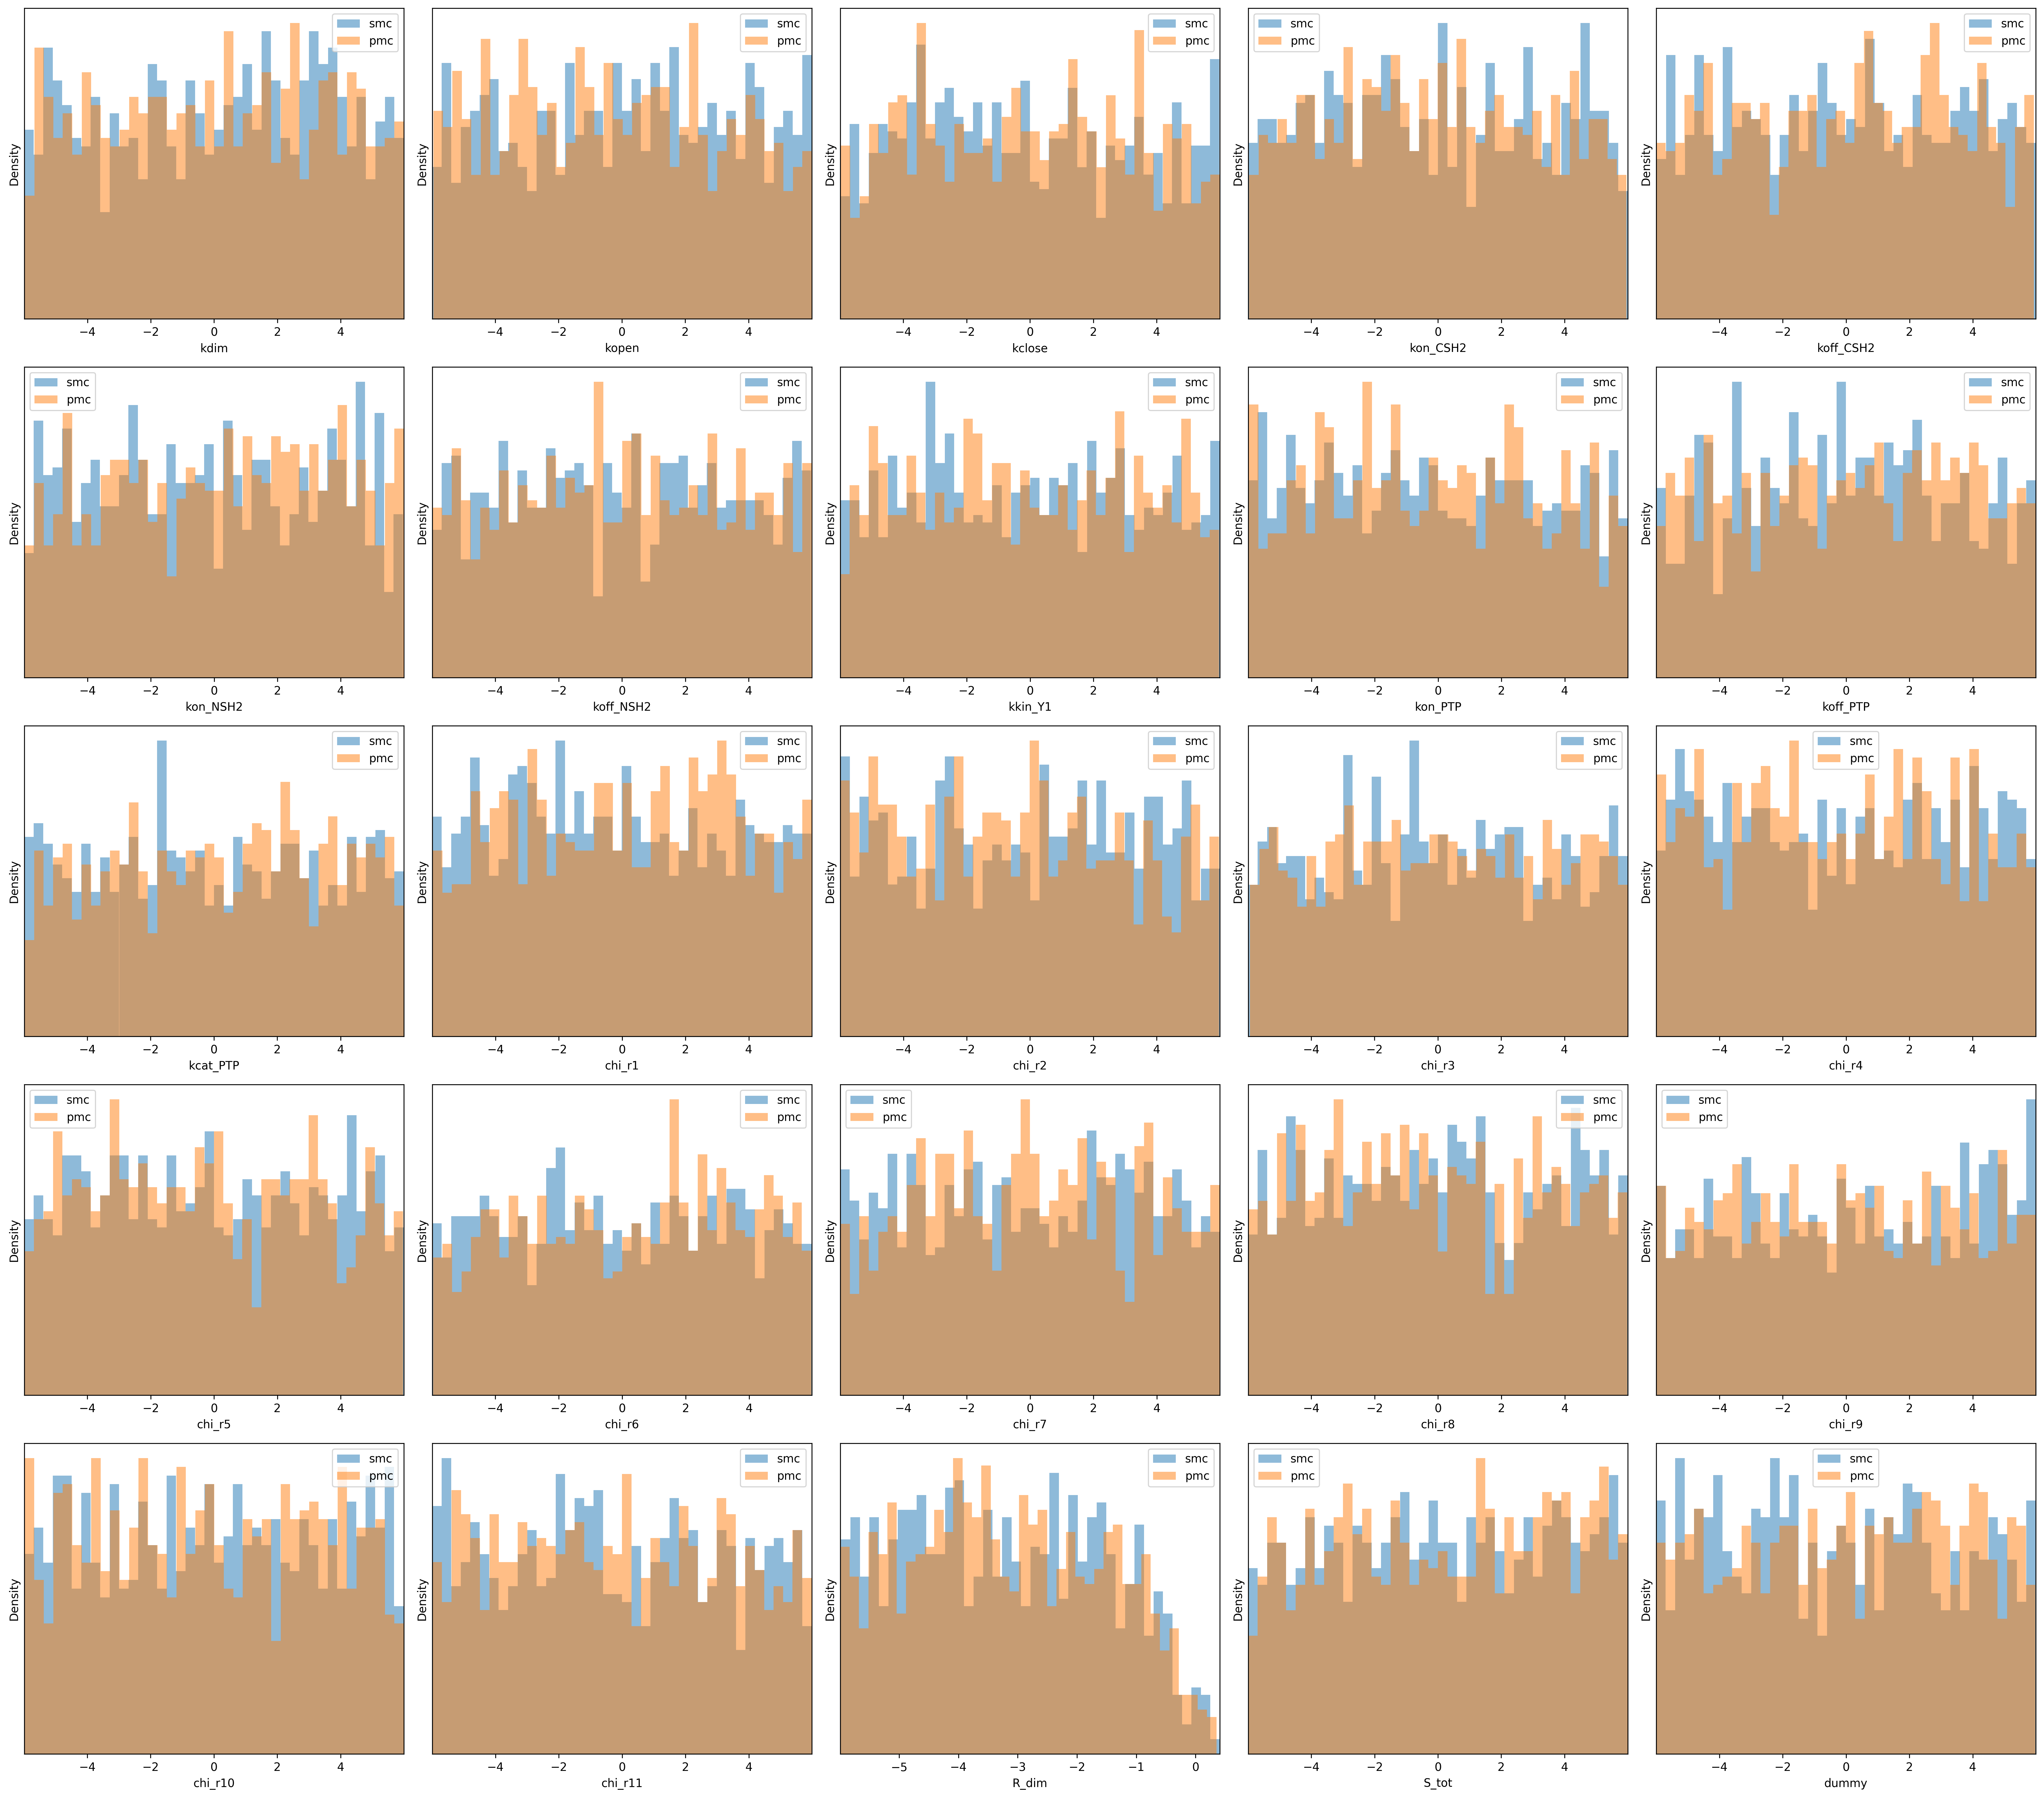

In [ ]:
# Get the names of the estimated parameters
fixed_idxs = mod_prob.problem.x_fixed_indices
par_names = mod_prob.problem.x_names
x=np.array(par_names)
mask=np.full(len(par_names),True,dtype=bool)
mask[fixed_idxs]=False
fit_par_names=x[mask]

par_bounds = mod_prob.bounds
histtype = "bar"
alpha=0.5

plt.figure(figsize=(25,22), dpi=300)
for i, par_name in enumerate(fit_par_names): 
	plt.subplot(5,5,i+1)
	for j in range(len(best_results)):      
		cur_result = best_results[j]
		plt.hist(cur_result.posterior_samples[:, i], lw=2, weights=cur_result.posterior_weights, color=colors[j], alpha=alpha,
			 cumulative=False, histtype=histtype, bins=40, label=cur_result.method) 
		plt.xlabel(par_name)
		plt.yticks([])
		plt.ylabel("Density")
		plt.margins(x=0)
	plt.legend()
plt.tight_layout()

In [7]:
from pypesto.objective import AggregatedObjective
from pypesto.objective.roadrunner.road_runner import RoadRunnerObjective
obj = mod_prob.problem.objective
og_obj = obj
if isinstance(obj, AggregatedObjective):
    subobjs = mod_prob.problem.objective.__dict__["_objectives"]
    for subobj in subobjs:
        if isinstance(subobj, RoadRunnerObjective):
            obj = subobj
        else:
            continue

## Plot fits to model data

/home/larkinit/anaconda3/envs/test1/lib/python3.12/site-packages/petab/v1/visualize/plotting.py:737: UserWarning: For plotId plot3 in column plotName contradictory settings (['observable_Grb2EGFRtotal' 'observable_Grb2Shctotal']). Proceeding with first entry (observable_Grb2EGFRtotal).
  subplot = Subplot.from_df(
/home/larkinit/anaconda3/envs/test1/lib/python3.12/site-packages/petab/v1/visualize/plotting.py:737: UserWarning: For plotId plot3 in column yLabel contradictory settings ([' Grb2EGFRtotal  [nM] ' ' Grb2Shctotal  [nM] ']). Proceeding with first entry ( Grb2EGFRtotal  [nM] ).
  subplot = Subplot.from_df(


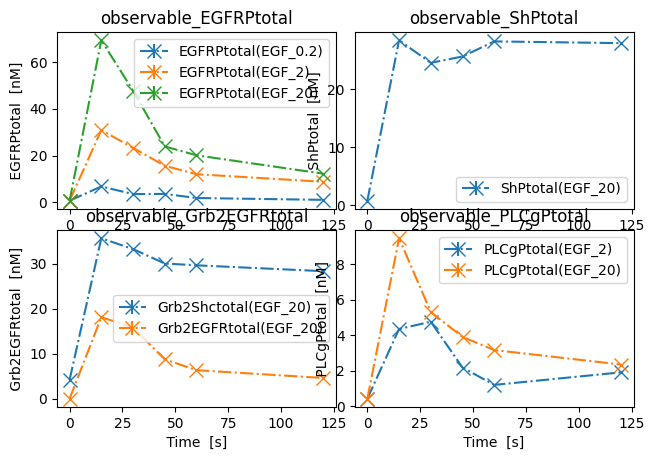

In [8]:
CI = 0.95
UPPER_PCT = (1 - (1-CI)/2)
LOWER_PCT = ((1-CI)/2)

petab_prob = mod_prob.petab_problem
ax_dict = plot_problem(petab_problem=petab_prob,) 
fig = plt.gcf()
# Change the figure size
fig.set_size_inches(6,4)

In [11]:
petab_prob.condition_df

,conditionName,S1
conditionId,,
C1,C1,6.8
C2,C2,68.0
C3,C3,680.0


/tmp/ipykernel_13747/3331166256.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  axs[0][0].plot(x, y, "ko", label="Data", zorder=2, color=cond_colors[0])


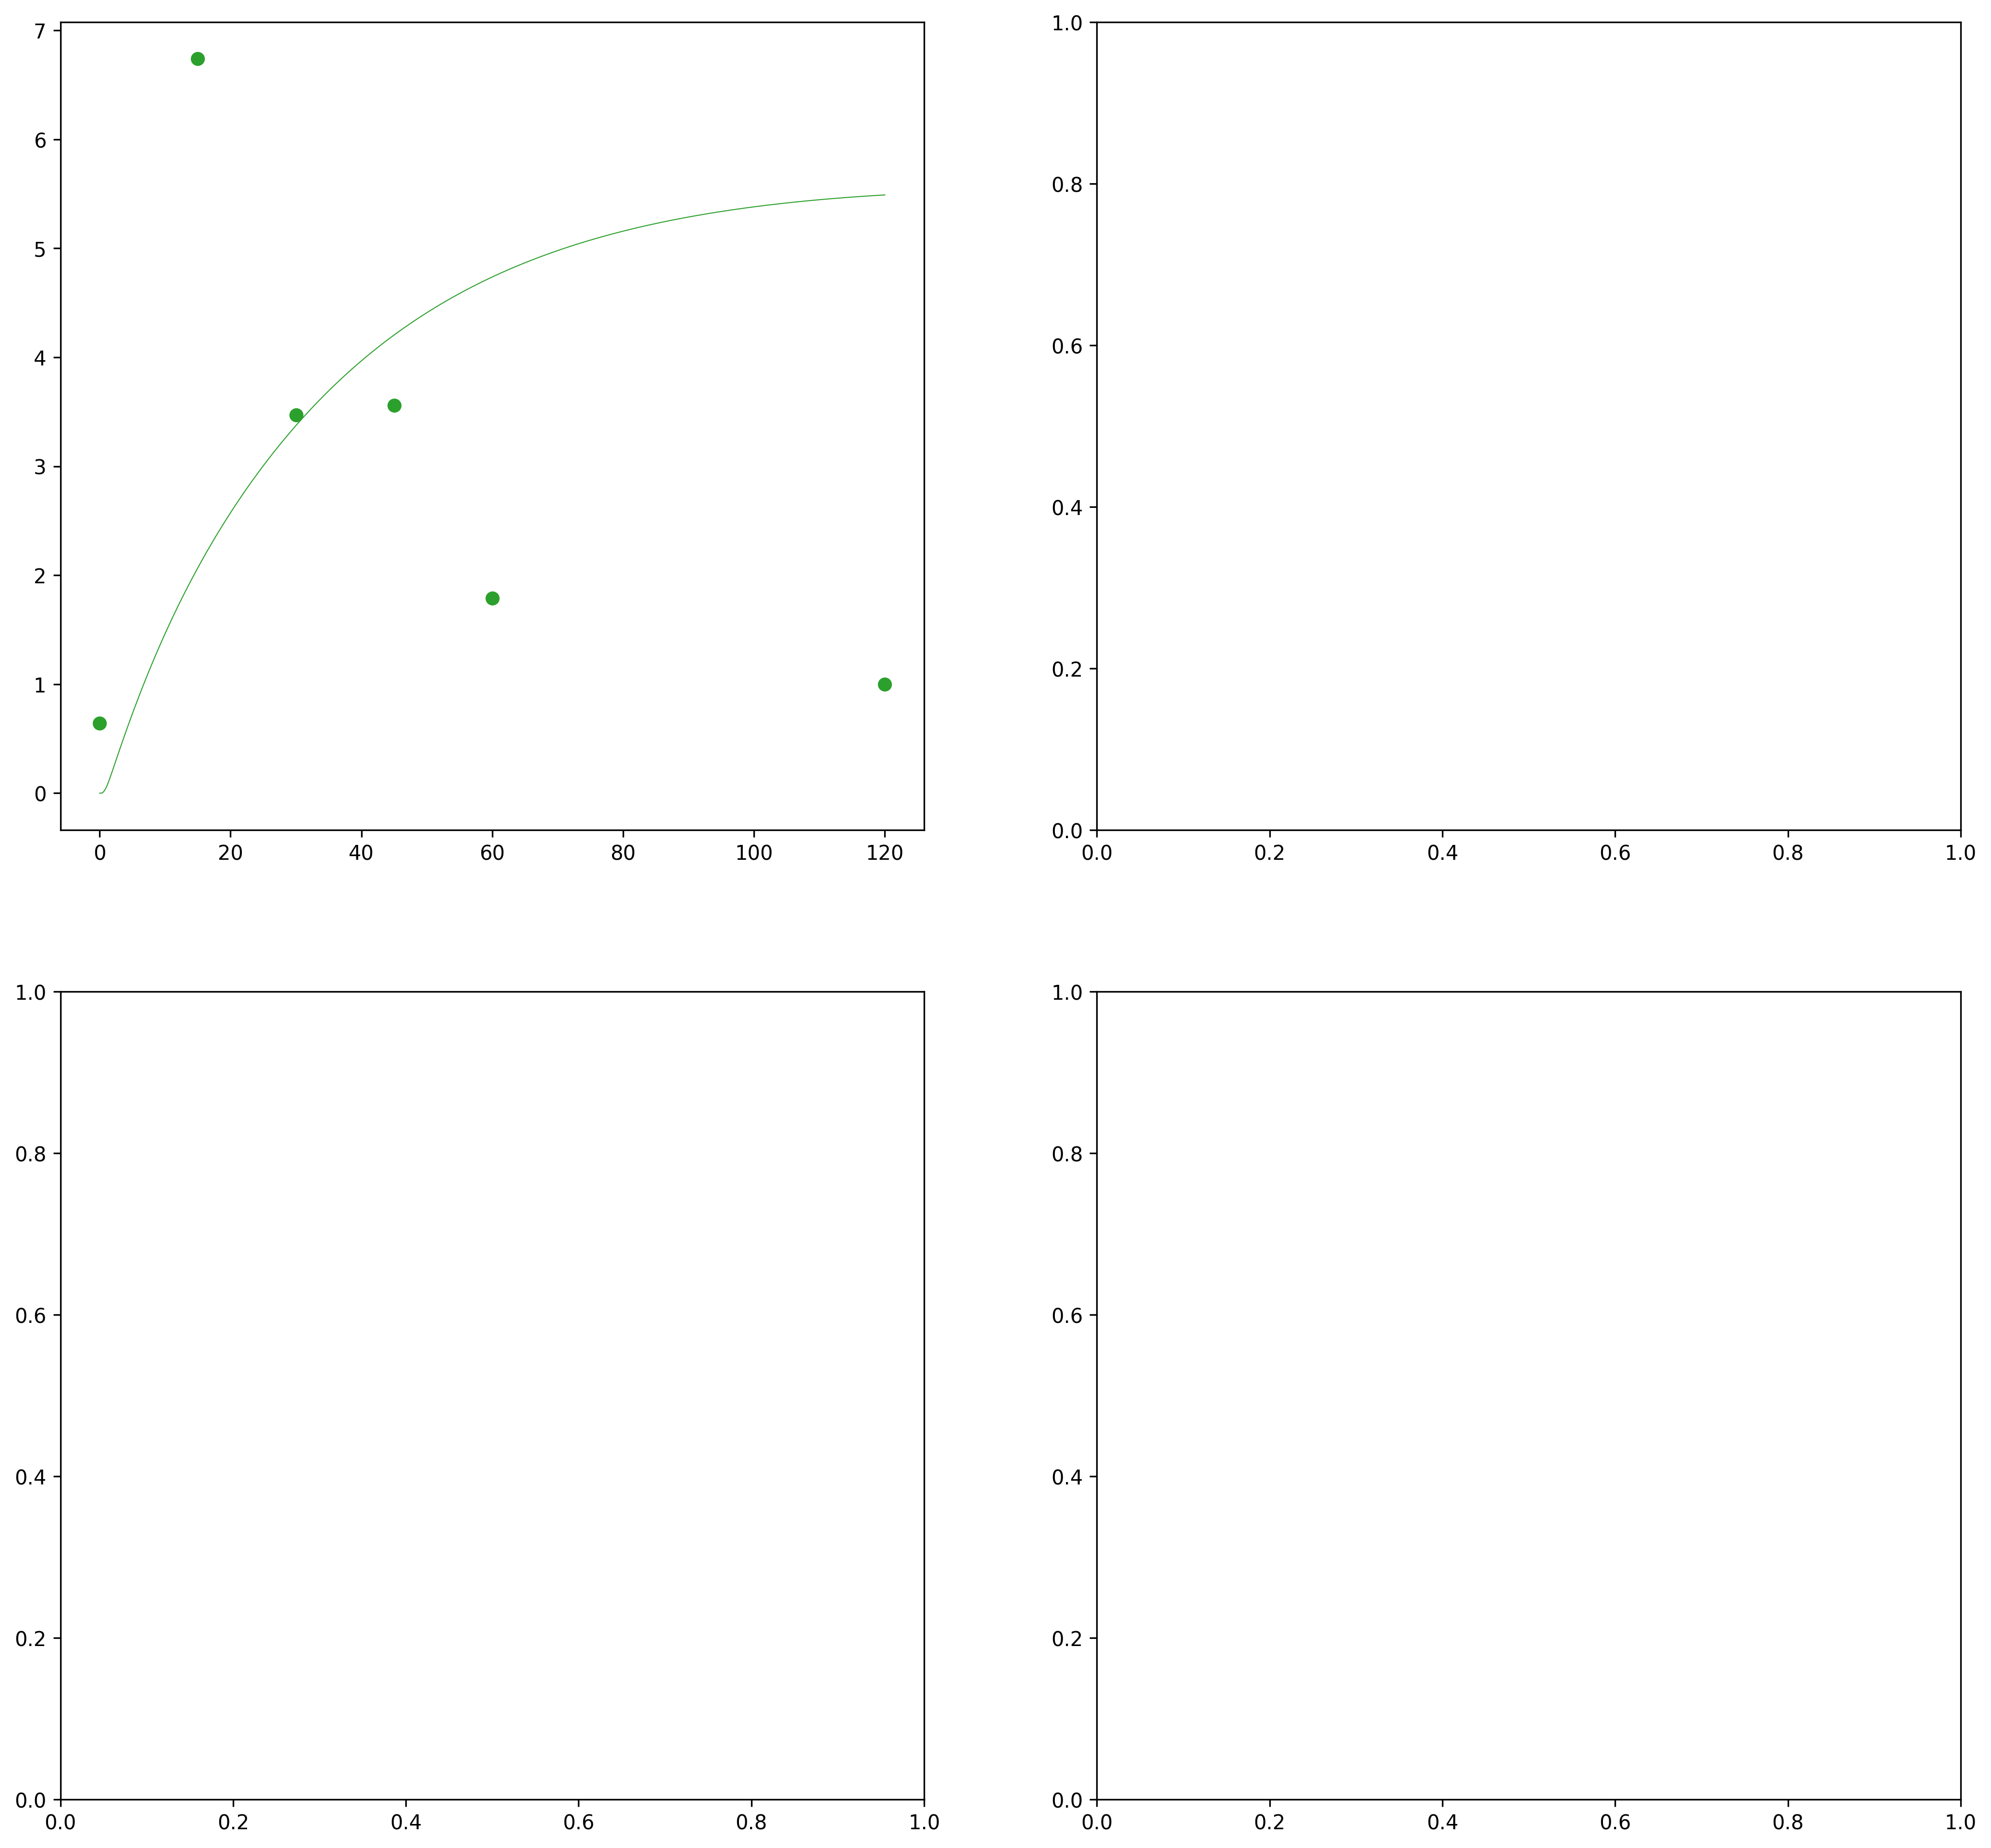

In [ ]:
measure_df = petab_prob.measurement_df
cond_df = petab_prob.condition_df
fig, axs = plt.subplots(2,2,figsize=(17,16), dpi=300)

#plt.plot(measure_df["time"], measure_df["measurement"], "ko", label="Data", zorder=2)

max_t = np.max(measure_df["time"])
n_sim_ts = int(120*100 + 1)
simu = obj.roadrunner_instance

cond_colors = ["tab:green", "tab:blue", "tab:orange"]
for name, init_condition in zip(cond_df["conditionName"].values,
                                cond_df["S1"].values):
	simu.resetAll()
	simu["S1"] = init_condition
	simu.timeCourseSelections = ["time", "EGFRPtotal", "PLCgPtotal", "ShPtotal", "Grb2Shctotal", "Grb2EGFRtotal"]
	og_sim = simu.simulate(0, 120, n_sim_ts)
	x = measure_df["time"].unique()
	y = measure_df[(measure_df["observableId"]=="observable_EGFRPtotal") & (measure_df["simulationConditionId"]==name)]["measurement"]
	axs[0][0].plot(x, y, "o", label="Data", zorder=2, color=cond_colors[0])
	axs[0][0].plot(og_sim[:, 0], og_sim[:, 1], color=cond_colors[0], lw=0.5, label="True Model Solution")
	break

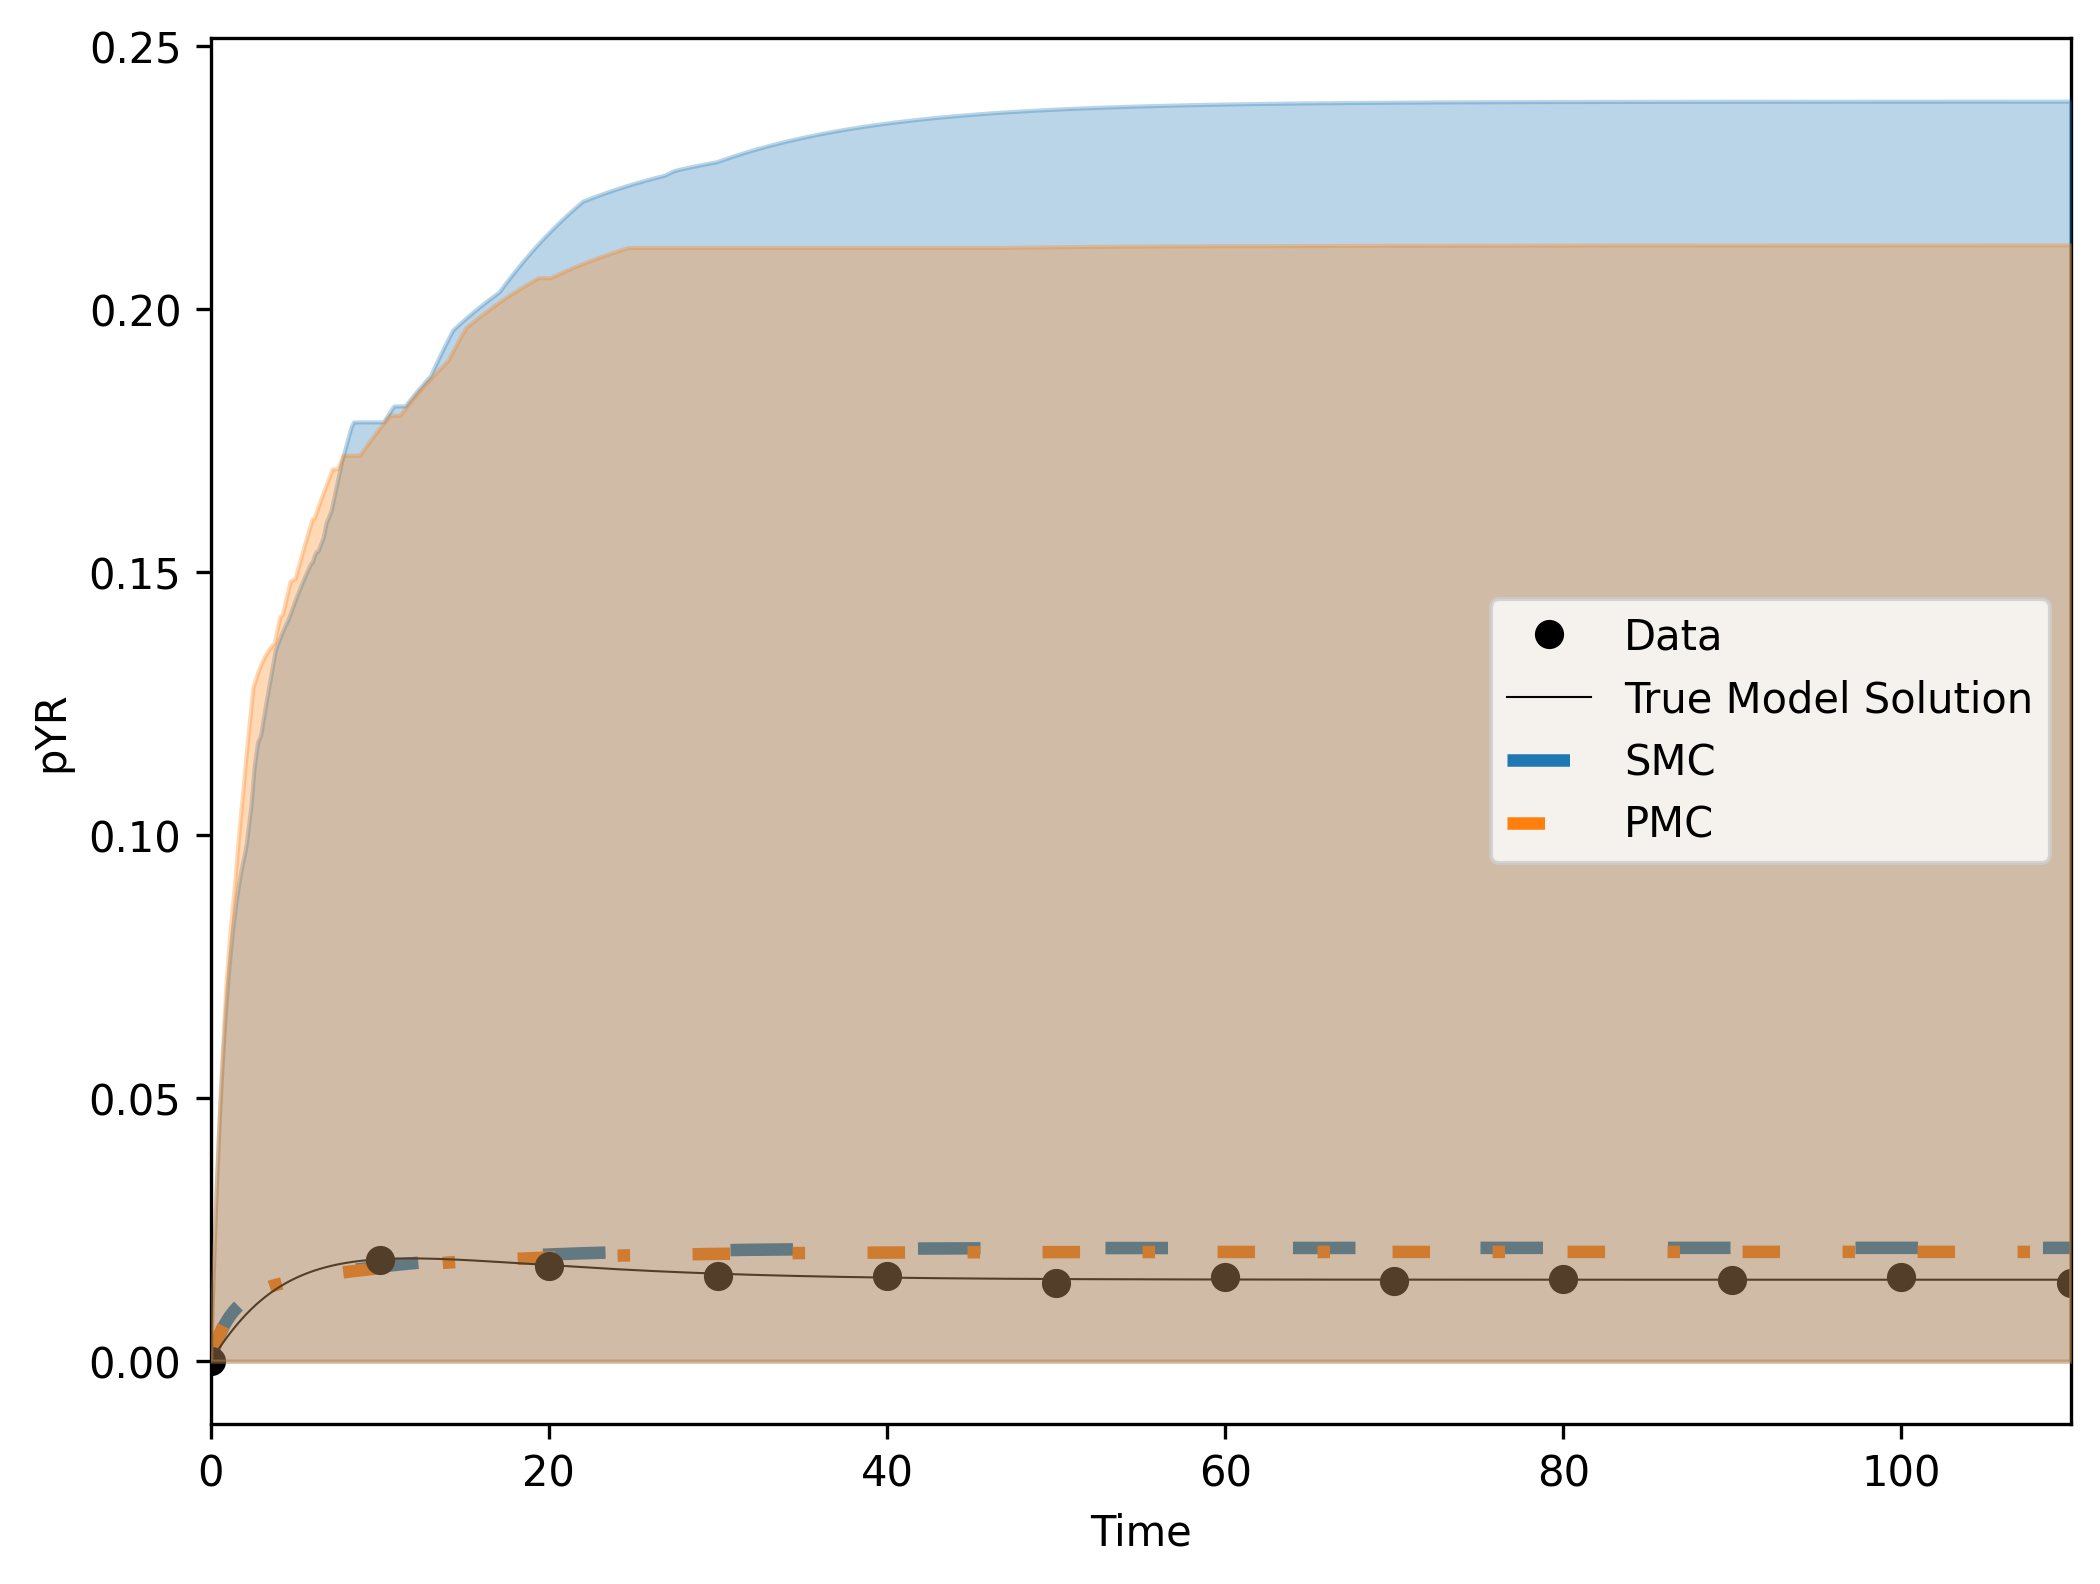

In [ ]:
measure_df = petab_prob.measurement_df
cond_df = petab_prob.condition_df
plt.figure(figsize=(8,6), dpi=300)

max_t = np.max(measure_df["time"])
n_sim_ts = int(120*100 + 1)
simu = obj.roadrunner_instance

lss = [(0,(5,10)), (0,(3,5,1,5))]#, (0,(1,4))]
for i, best in enumerate(best_results):
	pars = best.posterior_samples
	weights = best.posterior_weights

	all_sim_data = np.empty(shape=(n_sim_ts, pars.shape[0]))

	## Collect all of the runs simulation information
	for n, par in enumerate(pars):
		#sim = obj(par, mode="mode_fun", return_dict=True)["simulation_results"]["simCondition"]
		simu.resetAll()
		for name, x in zip(fit_par_names, par):
			simu[name] = x
		simu.reset()
		simu.timeCourseSelections = ["time", "pYR"]
		sim = simu.simulate(0, 110, n_sim_ts)
		all_sim_data[:, n] = sim[:, 1]
		sim_ts = sim[:, 0]
	n_ts = len(sim_ts)
	mean_sim_data = np.average(all_sim_data, weights=weights, axis=1)
	temp = np.array([weighted_quantile(x, [LOWER_PCT, UPPER_PCT], weights) for x in all_sim_data])
	#print(temp[0])
	low_sim_data = temp[:, 0]
	high_sim_data = temp[:, 1]
	
	plt.plot(sim_ts, mean_sim_data, lw=3, linestyle=lss[i], label=grouped_results[i].abbr, zorder=1, color=colors[i])
	plt.fill_between(sim_ts, low_sim_data, high_sim_data, zorder=3, alpha=0.3, color=colors[i])
plt.legend()
plt.margins(x=0);
plt.xlabel("Time"); plt.ylabel("pYR");